In [ ]:
!pip install spacy
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 32.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Importamos drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Abirmos el archivo
import pandas as pd

df = pd.read_csv('path')
df.head()

,role,genre,age,comment,kind_of_comment,complaint
0,alumno,hombre,29,El precio de la comida está carísimo para lo q...,negativo,precio
1,trabajador,hombre,48,"Todo bien, gracias por mantener la cafetería o...",neutro,NaN
2,madre,mujer,69,"Como madre de familia, el sabor de la comida d...",negativo,sabor
3,alumno,mujer,20,Me encanta la vibra de la cafetería; siempre h...,positivo,NaN
4,alumno,hombre,25,El precio está caro para lo que ofrecen y la a...,negativo,precio


In [ ]:
# Pre-procesamos el texto
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt_tab')
tqdm.pandas()

stopwords_es = stopwords.words('spanish')
no_stopwords = ['como', 'nada', 'ni', 'no', 'poco', 'sin', 'todo']
for word in no_stopwords:
  if word in stopwords_es:
      stopwords_es.remove(word)

lemmatizer = spacy.load("es_core_news_md")

def preprocessing(text):
  text = text.lower()
  text = re.sub(r'[^a-z0-9áéíóúüñ \t]', ' ', text)
  tokens = word_tokenize(text)
  tokens = [t for t in tokens if t not in stopwords_es]
  doc = lemmatizer(" ".join(tokens))
  lemmas = [token.lemma_ for token in doc if token.lemma_.strip()]

  return " ".join(lemmas)

# Eliminamos las filas cuyo comentario sea NaN
df = df.dropna(subset=['comment'])

# Aplicamos la fórmula de pre-procesamiento
df['clean_comment'] = df['comment'].progress_apply(preprocessing)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 991/991 [00:05<00:00, 192.83it/s]


,role,genre,age,comment,kind_of_comment,complaint,clean_comment
0,alumno,hombre,29,El precio de la comida está carísimo para lo q...,negativo,precio,precio comida carísimo entregar
1,trabajador,hombre,48,"Todo bien, gracias por mantener la cafetería o...",neutro,NaN,todo bien gracias mantener cafetería ordenado
2,madre,mujer,69,"Como madre de familia, el sabor de la comida d...",negativo,sabor,como madre familio sabor comida cafetería univ...
3,alumno,mujer,20,Me encanta la vibra de la cafetería; siempre h...,positivo,NaN,encantar vibrar cafetería siempre buen ambient...
4,alumno,hombre,25,El precio está caro para lo que ofrecen y la a...,negativo,precio,precio caro ofrecer atención dejar desear


In [ ]:
# Creamos el modelo para las predicciones (utilizamos SVM)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X = df['clean_comment']
y = df['kind_of_comment']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        min_df=5,
                        max_df=0.9,)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = LinearSVC()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

In [ ]:
# Imprimimos el reporte de precisión
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.964824120603015
              precision    recall  f1-score   support

    negativo       0.98      1.00      0.99        96
      neutro       0.91      0.91      0.91        34
    positivo       0.97      0.94      0.96        69

    accuracy                           0.96       199
   macro avg       0.95      0.95      0.95       199
weighted avg       0.96      0.96      0.96       199



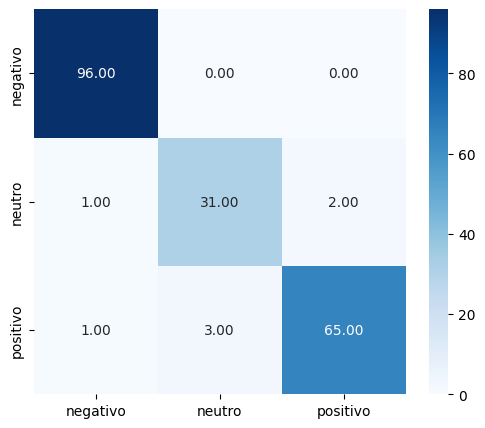

In [ ]:
# Imprimimos la matriz de cconfusión
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.show()

In [ ]:
# Definimos la función para predecir comentarios
def predictComment(text, model, debug=False):
  processed = preprocessing(text)

  if debug == True:
      print(processed)

  vector = tfidf.transform([processed])
  pred = model.predict(vector)[0]

  return pred

In [ ]:
new_comment = "Estuvo demasiado rico. Volvería a asistir."
print(preprocessing(new_comment))
predictComment(new_comment, model)

demasiado rico volver asistir


'positivo'